# NBA Most Valorated Player Analysis

In [159]:
import numpy as np
import pandas as pd
from pathlib import Path
from time import sleep
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

- votaciones: https://www.basketball-reference.com/awards/awards_1989.html#all_nba_mvp

In [160]:
data_path = Path("data")

years = (1980, 2026)

df_raw = pd.DataFrame(
    columns=[
        "Rank",
        "Player",
        "Age",
        "Tm",
        "First",
        "Pts Won",
        "Pts Max",
        "Share",
        "G",
        "MP",
        "PTS",
        "TRB",
        "AST",
        "STL",
        "BLK",
        "FG%",
        "3P%",
        "FT%",
        "WS",
        "WS/48",
        "Year",
    ],
    dtype="object",
)

for year in range(*years):
    df_y = pd.read_csv(data_path / f"mvp_{year}.csv")
    df_raw = pd.concat([df_raw, df_y])
df_raw

/tmp/ipykernel_5872/487629837.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_raw = pd.concat([df_raw, df_y])


,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Kareem Abdul-Jabbar,32,LAL,147.0,147.0,221,0.665,82,38.3,...,10.8,4.5,1.0,3.4,0.604,0.000,0.765,14.8,0.227,1980
1,2,Julius Erving,29,PHI,31.5,31.5,221,0.143,78,36.1,...,7.4,4.6,2.2,1.8,0.519,0.200,0.787,12.5,0.213,1980
2,3,George Gervin,27,SAS,19.0,19.0,221,0.086,78,37.6,...,5.2,2.6,1.4,1.0,0.528,0.314,0.852,10.6,0.173,1980
3,4,Larry Bird,23,BOS,15.0,15.0,221,0.068,82,36.0,...,10.4,4.5,1.7,0.6,0.474,0.406,0.836,11.2,0.182,1980
4,5T,Tiny Archibald,31,BOS,2.0,2.0,221,0.009,80,35.8,...,2.5,8.4,1.3,0.1,0.482,0.222,0.830,8.9,0.148,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,6,LeBron James,40,LAL,0.0,16.0,1000,0.016,70,34.9,...,7.8,8.2,1.0,0.6,0.513,0.376,0.782,7.7,0.152,2025
6,7,Cade Cunningham,23,DET,0.0,12.0,1000,0.012,70,35.0,...,6.1,9.1,1.0,0.8,0.469,0.356,0.846,5.9,0.115,2025
7,8,Anthony Edwards,23,MIN,0.0,12.0,1000,0.012,79,36.3,...,5.7,4.5,1.2,0.6,0.447,0.395,0.837,8.4,0.140,2025
8,9,Stephen Curry,36,GSW,0.0,2.0,1000,0.002,70,32.2,...,4.4,6.0,1.1,0.4,0.448,0.397,0.933,7.9,0.168,2025


## Preprocessing of Data

- Drop columns `First, Pts Won, Pts Max, WS`, since they are reiterative and lack information.
- Transform several columns to `int` type.
- Rename several columns
- Rename for `Nikola Jokic`, `Peja Sojakovic` and `Luca Doncic` to avoid troubles with encoding.

In [161]:
df = df_raw.reset_index(drop=True).drop(columns=["First", "Pts Won", "Pts Max", "WS"])
df["Player"] = df["Player"].replace(
    {
        "Nikola JokiÄ\x87": "Nikola Jokic",
        "Luka DonÄ\x8diÄ\x87": "Luka Doncic",
        "Peja StojakoviÄ\x87": "Peja Stojakovic",
    }
)
df["Age"] = df["Age"].astype(int)
df["Year"] = df["Year"].astype(int)
df["Rank"] = df["Rank"].apply(lambda x: int(x[:-1]) if str(x).endswith("T") else int(x))
df["G"] = df["G"].astype(int)
df = df.rename(
    columns={
        "G": "Games",
        "Tm": "Team",
        "TRB": "Rebs",
    }
)
dfwin: pd.DataFrame = df[df["Rank"] == 1].copy()
df

,Rank,Player,Age,Team,Share,Games,MP,PTS,Rebs,AST,STL,BLK,FG%,3P%,FT%,WS/48,Year
0,1,Kareem Abdul-Jabbar,32,LAL,0.665,82,38.3,24.8,10.8,4.5,1.0,3.4,0.604,0.000,0.765,0.227,1980
1,2,Julius Erving,29,PHI,0.143,78,36.1,26.9,7.4,4.6,2.2,1.8,0.519,0.200,0.787,0.213,1980
2,3,George Gervin,27,SAS,0.086,78,37.6,33.1,5.2,2.6,1.4,1.0,0.528,0.314,0.852,0.173,1980
3,4,Larry Bird,23,BOS,0.068,82,36.0,21.3,10.4,4.5,1.7,0.6,0.474,0.406,0.836,0.182,1980
4,5,Tiny Archibald,31,BOS,0.009,80,35.8,14.1,2.5,8.4,1.3,0.1,0.482,0.222,0.830,0.148,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,6,LeBron James,40,LAL,0.016,70,34.9,24.4,7.8,8.2,1.0,0.6,0.513,0.376,0.782,0.152,2025
454,7,Cade Cunningham,23,DET,0.012,70,35.0,26.1,6.1,9.1,1.0,0.8,0.469,0.356,0.846,0.115,2025
455,8,Anthony Edwards,23,MIN,0.012,79,36.3,27.6,5.7,4.5,1.2,0.6,0.447,0.395,0.837,0.140,2025
456,9,Stephen Curry,36,GSW,0.002,70,32.2,24.5,4.4,6.0,1.1,0.4,0.448,0.397,0.933,0.168,2025


In [162]:
del df_raw

## Análisis Exploratorio Descriptivo

### MVP winners per Age

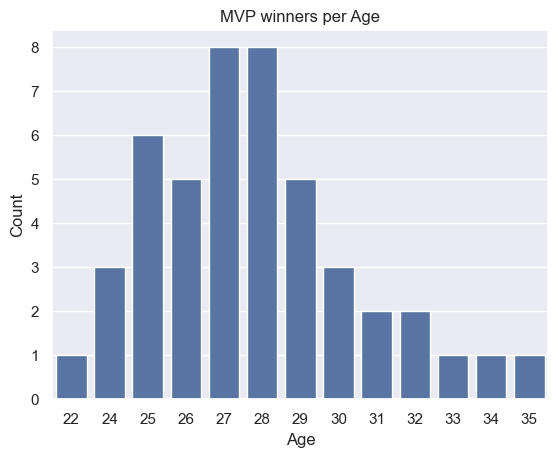

- Youngest player to win NBA MVP: Derrick Rose at 22 years old.

- Oldest player to win NBA MVP:   Karl Malone at 35 years old.

In [163]:
from IPython.display import display_markdown

sns.countplot(dfwin, x="Age")
plt.title("MVP winners per Age")
plt.ylabel("Count")
plt.show()
youngest = df.iloc[df[df["Rank"] == 1]["Age"].idxmin()]  # type: ignore
oldest = df.iloc[df[df["Rank"] == 1]["Age"].idxmax()]  # type: ignore
display_markdown(
    f"- Youngest player to win NBA MVP: {youngest["Player"]} at {youngest["Age"]} years old.",
    raw=True,
)
display_markdown(
    f"- Oldest player to win NBA MVP:   {oldest["Player"]} at {oldest["Age"]} years old.",
    raw=True,
)

### MVP winners per Team

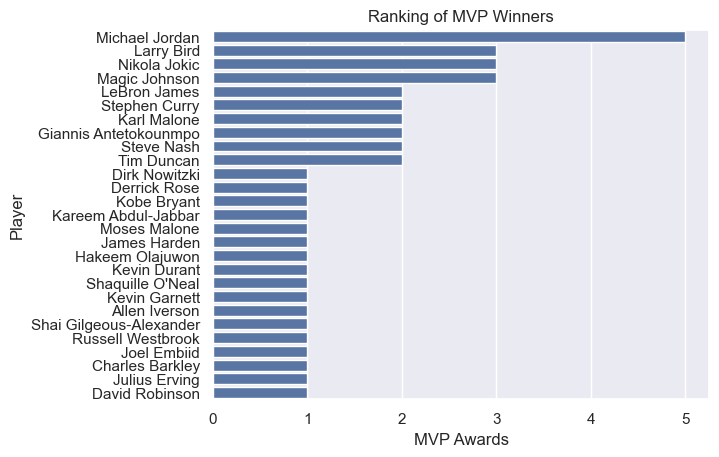

In [164]:
sns.barplot(
    dfwin.groupby(["Team", "Player"]).count().sort_values("Year", ascending=False),
    y="Player",
    x="Year",
)
plt.title("Ranking of MVP Winners")
plt.xlabel("MVP Awards")
plt.show()

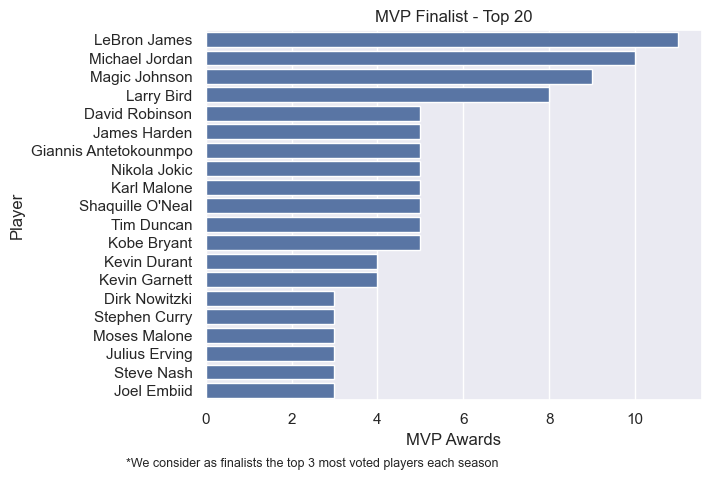

In [165]:
sns.barplot(
    df[df["Rank"] <= 3].groupby("Player").count().sort_values("Year", ascending=False).nlargest(20, "Year"),
    y="Player",
    x="Year",
)
plt.title("MVP Finalist - Top 20")
plt.figtext(0, -0.03, "*We consider as finalists the top 3 most voted players each season", ha="left", fontsize=9)
plt.xlabel("MVP Awards")
plt.show()

In [ ]:
df_wr = pd.DataFrame(df[df["Rank"] <= 3].groupby("Player").count().sort_values("Year", ascending=False)["Year"])
df_wr = df_wr.rename(columns={"Year": "Nominations"})
df_wr["Wins"] = dfwin.groupby("Player").count().sort_values("Year", ascending=False)["Year"]
df_wr["Wins"] = df_wr["Wins"].fillna(0).astype(int)
df_wr["WR"] = df_wr["Wins"] / df_wr["Nominations"]
df_wr["WR"] = df_wr["WR"].apply(lambda x: x*100 )
df_wr = df_wr.sort_values("WR",ascending=False)

,Nominations,Wins,WR
Player,,,
Russell Westbrook,1,1,100.000000
Derrick Rose,1,1,100.000000
Allen Iverson,1,1,100.000000
Stephen Curry,3,2,66.666667
Steve Nash,3,2,66.666667
Moses Malone,3,2,66.666667
Nikola Jokic,5,3,60.000000
Hakeem Olajuwon,2,1,50.000000
Shai Gilgeous-Alexander,2,1,50.000000


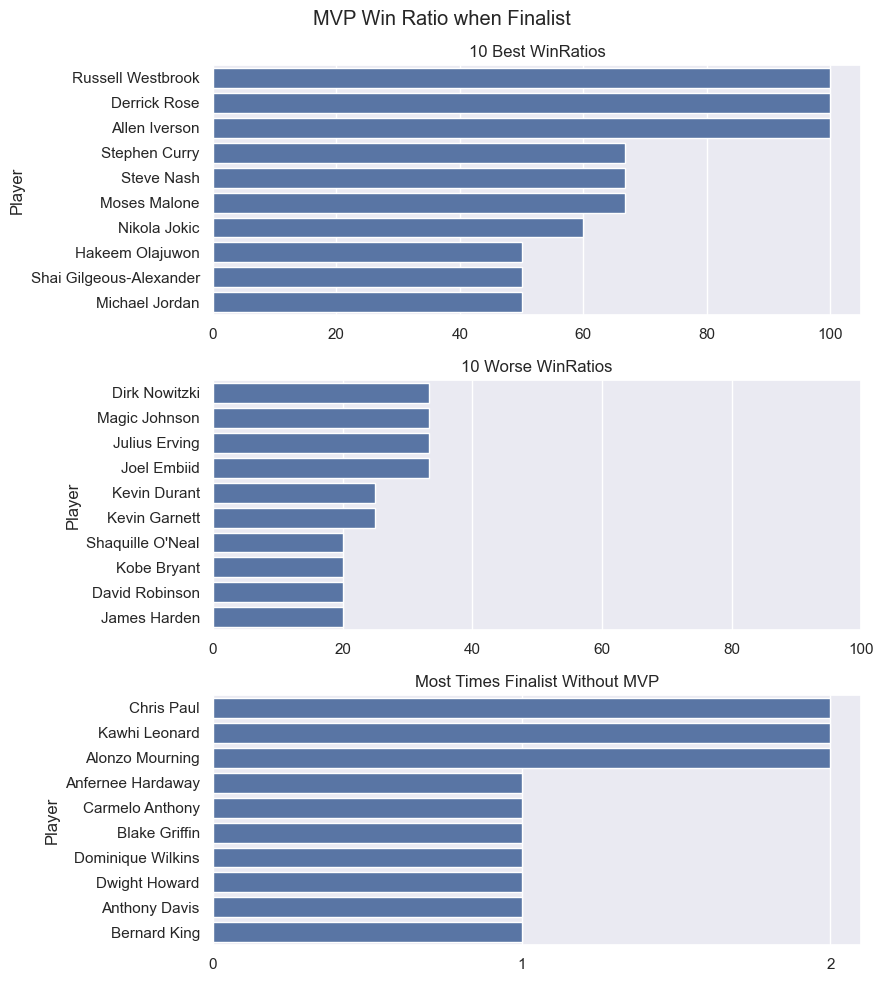

In [167]:
fig, ax = plt.subplots(3,1, figsize=(9,10))
sns.barplot(
    df_wr[df_wr["WR"] > 0].nlargest(10, "WR"),
    x="WR",
    y="Player",
    ax=ax[0],
)
ax[0].set_title("10 Best WinRatios")
sns.barplot(
    df_wr[df_wr["WR"] > 0].nsmallest(10, "WR").sort_values("WR",ascending=False),
    x="WR",
    y="Player",
    ax=ax[1],
)
ax[1].set_title("10 Worse WinRatios")
ax[1].set_xlim(0,100)
sns.barplot(
    df_wr[df_wr["WR"] == 0].nlargest(10, "Nominations").sort_values("Nominations",ascending=False),
    x="Nominations",
    y="Player",
    ax=ax[2],
)
ax[2].set_title("Most Times Finalist Without MVP")
ax[2].set_xticks([0,1,2])
[a.set_xlabel(None) for a in ax]
fig.suptitle("MVP Win Ratio when Finalist", )
fig.tight_layout()
plt.show()

### SGA and Jokić vs Means

Normalization using Z-score $\left(z = \cfrac{x - \mu}{\sigma}\right)$ over the range of values. Origin is stablished at the mean of the previous MVP winner stats (2024 and previous). Remember:

- $Z-score \in [-1, 1] \sim 65\%$ of values
- $Z-score \in [-2, 2] \sim 95\%$ of values

> Since $n > 30$ we asume normality in our data

In [168]:
df_rest_std = (
    dfwin[dfwin["Year"] < 2025].drop(columns=["Year", "Player", "Rank", "Team"]).std()
)
df_rest = (
    dfwin[dfwin["Year"] < 2025].drop(columns=["Year", "Player", "Rank", "Team"]).mean()
)
df_rest["Player"] = "Rest"
df_shai = df[df["Year"] == 2025].iloc[0]
df_jokic = df[df["Year"] == 2025].iloc[1]
df_comp = pd.concat([df_rest, df_rest_std, df_shai, df_jokic], axis=1).drop(
    ["Year", "Rank", "Team", "Player"]
)
df_comp.columns = ["Rest", "std","Shai", "Jokic"]
df_comp = df_comp.reset_index().rename(columns={"index": "Stat"})
df_comp_melt = (
    df_comp.set_index("Stat")
    .apply(lambda x: (x - x["Rest"])/x["std"], axis=1)
    .reset_index()
).drop(columns=["Rest", "std"])
df_comp_melt = df_comp_melt.melt(id_vars="Stat", var_name="Player", value_name="Value")

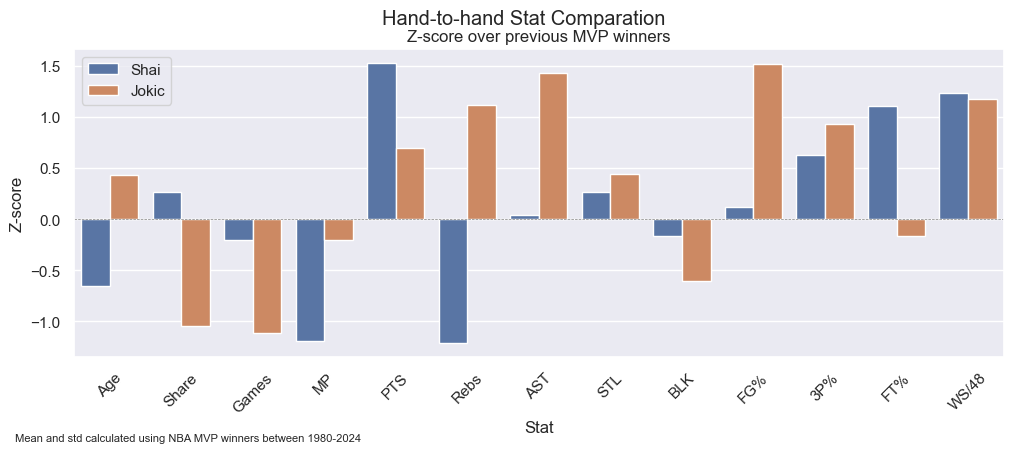

In [ ]:
fig, _ = plt.subplots(figsize=(12,4))
ax = sns.barplot(
    df_comp_melt,
    x = "Stat",
    y = "Value", 
    hue = "Player",
)
ax.get_legend().set_title("")
plt.suptitle("Hand-to-hand Stat Comparation")
plt.title("Z-score over previous MVP winners")
plt.xticks(rotation=45, ha="center")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.5)  
plt.ylabel("Z-score")
plt.figtext(0.22, -0.1, "Mean and std calculated using NBA MVP winners between 1980-2024", fontsize=8, ha="center")
plt.show()

### Clustering

## Modelos Predictivos

### Selección de Variables

In [170]:
df_full = df.copy()